In [1]:
!pip install git+https://github.com/rcmalli/keras-vggface
!pip install keras_applications
!pip install keras_vggface
!pip install mtcnn
!pip uninstall keras
!pip install keras==2.12


  Cloning https://github.com/rcmalli/keras-vggface to /tmp/pip-req-build-zi_36rj1
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface /tmp/pip-req-build-zi_36rj1
  Resolved https://github.com/rcmalli/keras-vggface to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
Found existing installation: keras 2.12.0
Uninstalling keras-2.12.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-2.12.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? Y
  Successfully uninstalled keras-2.12.0
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


In [6]:
import tensorflow as tf
import numpy as np
import keras
import keras_vggface
from keras_vggface.vggface import VGGFace
import mtcnn
import matplotlib.pyplot as plt
from keras.utils.data_utils import get_file
import keras_vggface.utils
import PIL
import os.path
import zipfile

In [9]:
zip_ref = zipfile.ZipFile ('/content/training.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [13]:
train_dataset = tf.keras.utils.image_dataset_from_directory('/content/training',
                                                        shuffle = True,
                                                        batch_size = 8,
                                                        image_size = (224, 224))

Found 147 files belonging to 2 classes.


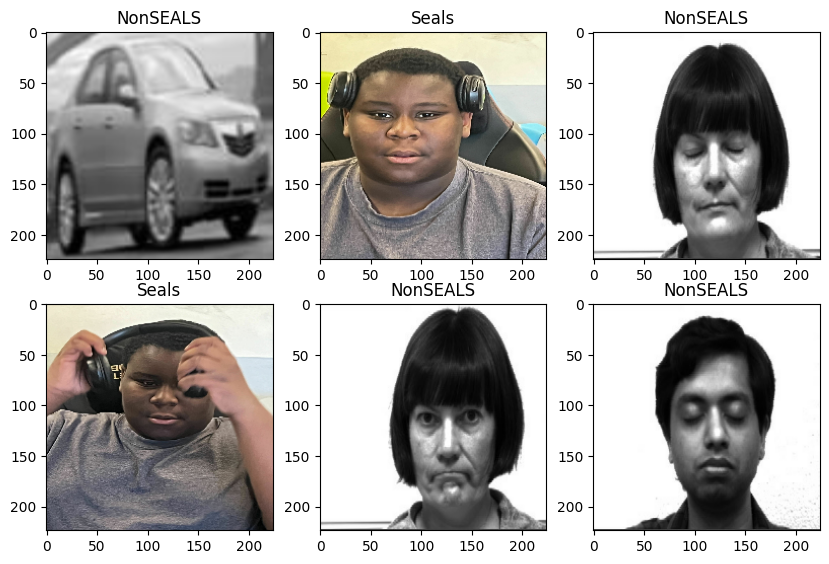

In [17]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

In [18]:
# This dose to improve the data for the Model
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),

])

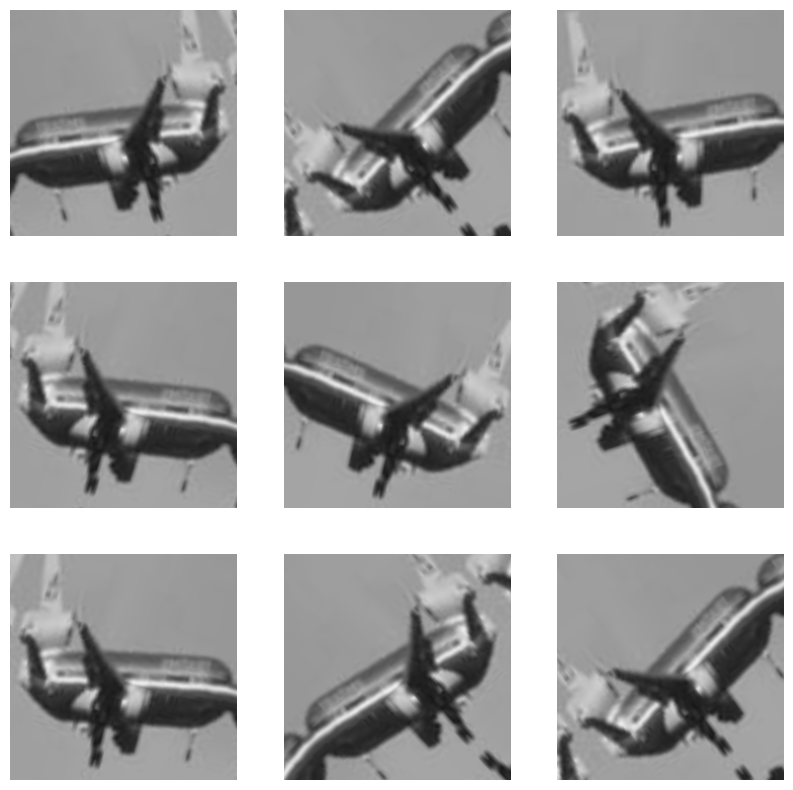

In [19]:
# Ploting the images in the training data

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] /255)
    plt.axis('off')

In [20]:
# This is loading the Model from the Libary
vggface_resnet_base = VGGFace(model='resnet50', include_top=False, input_shape=(224,224,3))

94694792/94694792 [==============================] - 0s 0us/step


In [21]:
# This is new head will be Fine_Tuning
from keras.layers import Flatten, Dense, Input

nb_class = 1

# Always frezze the base Model
vggface_resnet_base.trainable=False

# Defining the input
inputs = tf.keras.Input(shape=(224,224,3))

x = data_augmentation(inputs)

x = vggface_resnet_base(x)

x = Flatten(name='flatten')(x)

out = Dense(nb_class, name='classifier')(x)

model = keras.Model(inputs, out)

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
initial_epochs = 20

history = model.fit(train_dataset, epochs=initial_epochs)

Epoch 1/20
19/19 [==============================] - 9s 121ms/step - loss: 0.6304 - accuracy: 0.6531
Epoch 2/20
19/19 [==============================] - 3s 111ms/step - loss: 0.5254 - accuracy: 0.6667
Epoch 3/20
19/19 [==============================] - 2s 80ms/step - loss: 0.4960 - accuracy: 0.6735
Epoch 4/20
19/19 [==============================] - 2s 72ms/step - loss: 0.5339 - accuracy: 0.6735
Epoch 5/20
19/19 [==============================] - 2s 75ms/step - loss: 0.4481 - accuracy: 0.6939
Epoch 6/20
19/19 [==============================] - 2s 98ms/step - loss: 0.4458 - accuracy: 0.7143
Epoch 7/20
19/19 [==============================] - 2s 77ms/step - loss: 0.4394 - accuracy: 0.7211
Epoch 8/20
19/19 [==============================] - 2s 74ms/step - loss: 0.4369 - accuracy: 0.7347
Epoch 9/20
19/19 [==============================] - 2s 74ms/step - loss: 0.4126 - accuracy: 0.7211
Epoch 10/20
19/19 [==============================] - 2s 72ms/step - loss: 0.3795 - accuracy: 0.7687
Epoch 1

Predictions:
 [0 0 0 1 0 0 0 0]
Labels:
 [0 0 0 1 0 1 0 0]


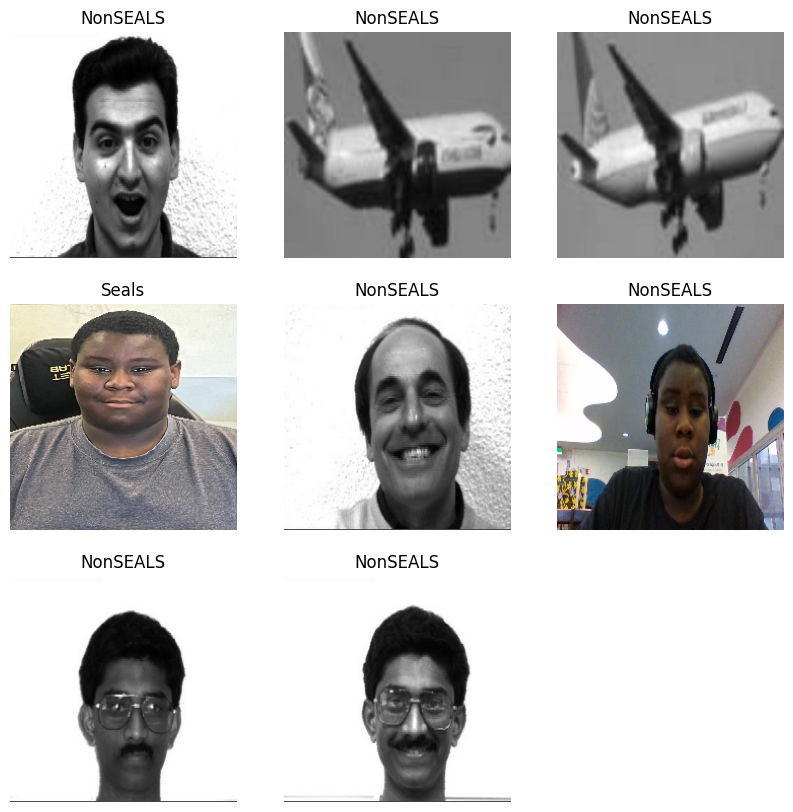

In [44]:
image_batch, label_batch = train_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()


predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(8):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")